In [5]:
import pandas as pd
import numpy as np
import random
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
from gensim.models import word2vec

Using TensorFlow backend.


In [6]:
data1 = pd.read_csv('file_output_1000_example1.csv')
data2 = pd.read_csv('file_output_1000_example2.csv')
data3 = pd.read_csv('file_output_1000_example3.csv')
data4 = pd.read_csv('file_output_1000_example4.csv')
data5 = pd.read_csv('file_output_1000_example5.csv')
metacritics_album = pd.read_csv('arquivos_experimentos/output_abstract_metacritic_album.csv')
metacritics_album = metacritics_album.iloc[:,1:]
metacritics_album.dropna(inplace=True)
metacritics_movies = pd.read_csv('arquivos_experimentos/output_abstract_metacritic_movies.csv')
metacritics_movies = metacritics_movies.iloc[:,1:]
metacritics_movies.dropna(inplace=True)
cities = pd.read_csv('arquivos_experimentos/output_abstract_cities.csv')
cities = cities.iloc[:,1:]
cities.dropna(inplace=True)

metacritic_target = list()
for i in range(metacritics_album.shape[0]):
    metacritic_target.append(ast.literal_eval(metacritics_album.iloc[i,1])[0])
metacritics_album['class_target'] = metacritic_target
metacritics_album.rename({'types':'other_class'},axis=1,inplace=True)

metacritic_movie_target = list()
for i in range(metacritics_movies.shape[0]):
    metacritic_movie_target.append(ast.literal_eval(metacritics_movies.iloc[i,1])[0])
metacritics_movies['class_target'] = metacritic_movie_target
metacritics_movies.rename({'types':'other_class'},axis=1,inplace=True)

cities_target = list()
for i in range(cities.shape[0]):
    cities_target.append(ast.literal_eval(cities.iloc[i,1])[0])
cities['class_target'] = cities_target
cities.rename({'types':'other_class'}, axis=1, inplace=True)

data = pd.concat([data1,data2,data3,data4,data5,metacritics_album,metacritics_movies,cities])

/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
examples = data.abstract.values
targets = range(0,len(examples))

In [8]:
len(np.unique(targets))

320730

In [9]:
def text_word_sequence(texts):
    abstract_sentences = list()
    for text in tqdm(texts):
        abstract_sentences.append(text_to_word_sequence(text))
    return abstract_sentences
abstract_sentences = text_word_sequence(examples)

100%|██████████| 320730/320730 [00:15<00:00, 20919.13it/s]


In [ ]:
model = word2vec.Word2Vec(size=300, sg=1, workers=10)

model.build_vocab(sentences=abstract_sentences)

model.train(sentences=abstract_sentences, epochs=20, total_examples=len(abstract_sentences))

model.save('siamesa_w2v.model')

In [10]:
model = word2vec.Word2Vec.load('siamesa_w2v.model')

In [11]:
quantity_of_embeddings = len(model.wv.vocab)

In [12]:
def tokenize_text(quantity_of_embeddings, examples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(examples)
    sequences = tokenizer.texts_to_sequences(examples)
    return (sequences, tokenizer)
sequences, tokenizer = tokenize_text(quantity_of_embeddings,examples)

In [13]:
embedding_matrix = np.zeros((len(tokenizer.word_index), 300))
for word, i in tqdm(tokenizer.word_index.items()):
    if word in model and i < quantity_of_embeddings:
        embedding_matrix[i] = model[word]

  0%|          | 0/548675 [00:00<?, ?it/s]/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
100%|██████████| 548675/548675 [00:02<00:00, 213380.36it/s]


In [14]:
sequences_pad = pad_sequences(sequences,maxlen=300)

In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(sequences_pad,targets,test_size=0.10, random_state=42)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.2,random_state=42)

In [16]:
def get_batches(x,y, batch_size):
    for i in range(0,len(x),batch_size):
        examples_final1 = np.zeros((batch_size*batch_size, 300))
        examples_final2 = np.zeros((batch_size*batch_size, 300))
        targets_final = np.zeros((batch_size*batch_size,1),dtype=int)

        examples = x[i:i+batch_size] 
        targets = y[i:i+batch_size]
        cont = 0
        for j in range(len(examples)):
            for z in range(len(examples)):
                examples_final1[cont]= examples[j]
                examples_final2[cont]= examples[z]
                y1 = set(data.iloc[targets[j]].other_class.split(','))
                y2 = set(data.iloc[targets[z]].other_class.split(','))
                targets_final[cont]=len(y1.intersection(y2))
                cont+=1
        yield [examples_final1,examples_final2],targets_final

# fórmula n(n-1)/2

In [17]:
def generator(x,y):
    for i in range(len(x)):
        for z in range(i+1,len(x)):
            y1 = set(data.iloc[y[i]].other_class.split(','))
            y2 = set(data.iloc[y[z]].other_class.split(','))
            targets_final = len(y1.intersection(y2))
#             yield ({'input1':x[i],'input2':x[z]}, {'output':targets_final})
            yield [x[i], x[z]], targets_final


In [18]:
def generator2(x,y,batch_size):
    batch_features1 = np.zeros((batch_size, 300))
    batch_features2 = np.zeros((batch_size, 300))
    batch_labels = np.zeros((batch_size,1),dtype=int)
#     encoder = preprocessing.LabelBinarizer()
    list_y = list(y)
    while True:
        for i in range(batch_size):
            index1= random.choice(y)
            index2= random.choice(y)
            index1 = list_y.index(index1)
            index2 = list_y.index(index2)
            batch_features1[i] = x[index1]
            batch_features2[i] = x[index2]
            y1 = set(data.iloc[y[index1]].other_class.split(','))
            y2 = set(data.iloc[y[index2]].other_class.split(','))
            batch_labels[i] = len(y1.intersection(y2))
#         labels = encoder.fit_transform(batch_labels)
#         labels = pad_sequences(labels,maxlen=8, padding='post')
        yield [batch_features1, batch_features2],batch_labels
            

   

In [19]:
a = generator2(x_train,y_train,32)

In [20]:
b,c= next(a)

In [21]:
c

array([[0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [3],
       [2],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0]])

In [22]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

L1_distance = lambda x: K.abs(x[0]-x[1])

def cosine_distance(left,right):
    x = K.l2_normalize(left, axis=-1)
    y = K.l2_normalize(right, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

In [23]:
# exponent_neg_manhattan_distance(np.array([1,2,3,4,5]),np.array([2,2,3,2,1]))

In [24]:
from keras.layers import Embedding,Input, Conv1D, MaxPooling1D, Dense,merge,Flatten, Dropout, GlobalMaxPool1D, Concatenate, Lambda,Activation
from keras.initializers import random_uniform
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras.models import Model, Sequential

channels = 100
size_feature_map = 3
size_feature_map_2 = 4
size_feature_map_3 = 5
dropout = 0.25
dense1 = 50
dense2 = 100
embedding_size = 300

<p>generator retornando um vetor de 8 funciona com mean_squared_error, accuracy fica em torno de 75</p>
generator retornando apenas 1 valor e não usando função de ativação na saída e usando mean_squared_error acurácia
degrada a partir da terceira época

In [25]:
input1 = Input(shape=(embedding_size,), dtype='int32', name='input1')
input2 = Input(shape=(embedding_size,), dtype='int32', name='input2')

convnet = Sequential()
convnet.add(Embedding(len(tokenizer.word_index),
                            embedding_size,
                            input_length=300,
                            weights=[embedding_matrix],
                            trainable=False))
convnet.add(Dropout(dropout))
convnet.add(Conv1D(channels, size_feature_map, activation='relu',padding='SAME'))
convnet.add(MaxPooling1D(2, padding='SAME'))

convnet.add(Conv1D(channels, size_feature_map, activation='relu',padding='SAME'))

convnet.add(Flatten())
convnet.add(Dense(dense2, activation='relu', name='fc1_x'))

left = convnet(input1)
right = convnet(input2)
distance_layer = Lambda(function=lambda z:cosine_distance(z[0],z[1]), output_shape=(1,))([left,right])

# distance_layer = Lambda(function=lambda z:L1_distance(z), output_shape=lambda x:x[0])([left,right])

# pred = Dense(1)(distance_layer)
# optmizer = Adam(lr=0.0005)
model_cnn = Model([input1,input2],distance_layer)
model_cnn.compile(loss='cosine_proximity',
              optimizer='rmsprop',
              metrics=['acc'])

model_cnn.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 300)          0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 300)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 100)          166222800   input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [26]:
gen = get_batches(x_train,y_train,8)
# gen = generator2(x_train,y_train,32)
gen_val = get_batches(x_val, y_val,8)
checkpoint = ModelCheckpoint('weights-best-siamesemodel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model_cnn.fit_generator(generator=gen, steps_per_epoch=len(x_train)/512, validation_steps=15 ,validation_data=gen_val, epochs=40, verbose=2, callbacks=callbacks_list)

Epoch 1/40
 - 19s - loss: 0.3232 - acc: 0.6766 - val_loss: 0.2771 - val_acc: 0.7229

Epoch 00001: val_acc improved from -inf to 0.72292, saving model to weights-best-siamesemodel.hdf5
Epoch 2/40
 - 18s - loss: 0.3213 - acc: 0.6787 - val_loss: 0.2958 - val_acc: 0.7042

Epoch 00002: val_acc did not improve from 0.72292
Epoch 3/40
 - 18s - loss: 0.3236 - acc: 0.6764 - val_loss: 0.2854 - val_acc: 0.7146

Epoch 00003: val_acc did not improve from 0.72292
Epoch 4/40
 - 18s - loss: 0.3155 - acc: 0.6845 - val_loss: 0.2896 - val_acc: 0.7104

Epoch 00004: val_acc did not improve from 0.72292
Epoch 5/40
 - 19s - loss: 0.3126 - acc: 0.6874 - val_loss: 0.2646 - val_acc: 0.7354

Epoch 00005: val_acc improved from 0.72292 to 0.73542, saving model to weights-best-siamesemodel.hdf5
Epoch 6/40
 - 18s - loss: 0.3036 - acc: 0.6946 - val_loss: 0.3125 - val_acc: 0.6875

Epoch 00006: val_acc did not improve from 0.73542
Epoch 7/40
 - 18s - loss: 0.3148 - acc: 0.6850 - val_loss: 0.2771 - val_acc: 0.7229

Epoc

In [27]:
len(x_train)/512

451.025390625

In [28]:
model_cnn.load_weights('weights-best-siamesemodel.hdf5')
gen = get_batches(x_test,y_test,16)
model_cnn.evaluate_generator(gen,steps=10)

[0.30859375, 0.69140625]

In [29]:
l1 = model_cnn.layers[2](input1)

In [30]:
model2 = Model(input1,l1)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          (None, 300)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 100)               166222800 
Total params: 166,222,800
Trainable params: 1,620,300
Non-trainable params: 164,602,500
_________________________________________________________________


In [240]:
# sequences_movies, _= tokenize_text(quantity_of_embeddings,metacritics_movies.abstract.values)
# pad_sequences_movies = pad_sequences(sequences_movies,maxlen=embedding_size)
# sequences_cities, _= tokenize_text(quantity_of_embeddings,cities.abstract.values)
# pad_sequences_cities = pad_sequences(sequences_cities,maxlen=embedding_size)

sequences_album, _ = tokenize_text(quantity_of_embeddings, metacritics_album.abstract.values)
pad_sequences_album = pad_sequences(sequences_album, maxlen=embedding_size)

In [241]:
type(sequences_album)

list

In [242]:
# embeddies_cities_final = model2.predict(pad_sequences_cities)
# embeddies_movies_final = model2.predict(pad_sequences_movies)
embeddies_album_final = model2.predict(pad_sequences_album)

In [33]:
embeddies_cities_final.shape

(154, 100)

In [243]:
def assemble_embedding_dict(entity,embedding):
    embeddies_dict_final = dict()
    for i in range(len(entity)):
        embeddies_dict_final['dbo:'+entity[i]] = embedding[i]
    return embeddies_dict_final

In [244]:
# entities_cities = cities.entity.values
# entities_movies = metacritics_movies.entity.values
entities_album = metacritics_album.entity.values

In [245]:
np.save('embeddings/album_embeddings_siamese.npy',assemble_embedding_dict(entities_album,embeddies_album_final))

In [81]:
data_tsne_cities = assemble_embedding_dict(entities_cities,embeddies_cities_final)
data_tsne_movies = assemble_embedding_dict(entities_movies,embeddies_movies_final)

In [82]:
from sklearn.manifold import TSNE

In [83]:
def list_embeddings(data_tsne):
    list_embeddings = list()
    for i in data_tsne.values():
        list_embeddings.append(i)
    return list_embeddings
list_cities = list_embeddings(data_tsne_cities)
list_movies = list_embeddings(data_tsne_movies)

In [84]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_cities = tsne.fit_transform(list_cities)
tsne_results_movies = tsne.fit_transform(list_movies)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 154 samples in 0.000s...
[t-SNE] Computed neighbors for 154 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 154 / 154
[t-SNE] Mean sigma: 0.871978
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.527908
[t-SNE] Error after 300 iterations: 0.292286
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1799 samples in 0.024s...
[t-SNE] Computed neighbors for 1799 samples in 0.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1799
[t-SNE] Computed conditional probabilities for sample 1799 / 1799
[t-SNE] Mean sigma: 0.389564
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.556393
[t-SNE] Error after 300 iterations: 0.841305


In [40]:
from ggplot import *

/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [97]:
data_frame_embedding_c = pd.DataFrame(tsne_results_cities, columns=['embeddings_1','embeddings_2'])
data_frame_embedding_v = pd.DataFrame(tsne_results_movies, columns=['embeddings_1','embeddings_2'])

In [98]:
data_frame_embedding_c['entities']=['cities' for i in entities_cities]
data_frame_embedding_v['entities']=['movies'for i in entities_movies]

In [199]:
data_frame_final = pd.concat([data_frame_embedding_c,data_frame_embedding_v],ignore_index=True)

In [200]:
from sklearn.utils import shuffle
data_frame_final = shuffle(data_frame_final)


In [222]:
idx1 = data_frame_final[data_frame_final.entities=='movies'].iloc[:30].index.tolist()
idx2 = data_frame_final[data_frame_final.entities=='cities'].iloc[:30].index.tolist()

In [223]:
idx_final = idx1 + idx2

In [224]:
data_frame_final.iloc[9]

embeddings_1   -6.05553
embeddings_2    1.68674
entities         movies
Name: 1452, dtype: object

In [225]:
data_frame_final.loc[1,'embeddings_2']

-5.0866218

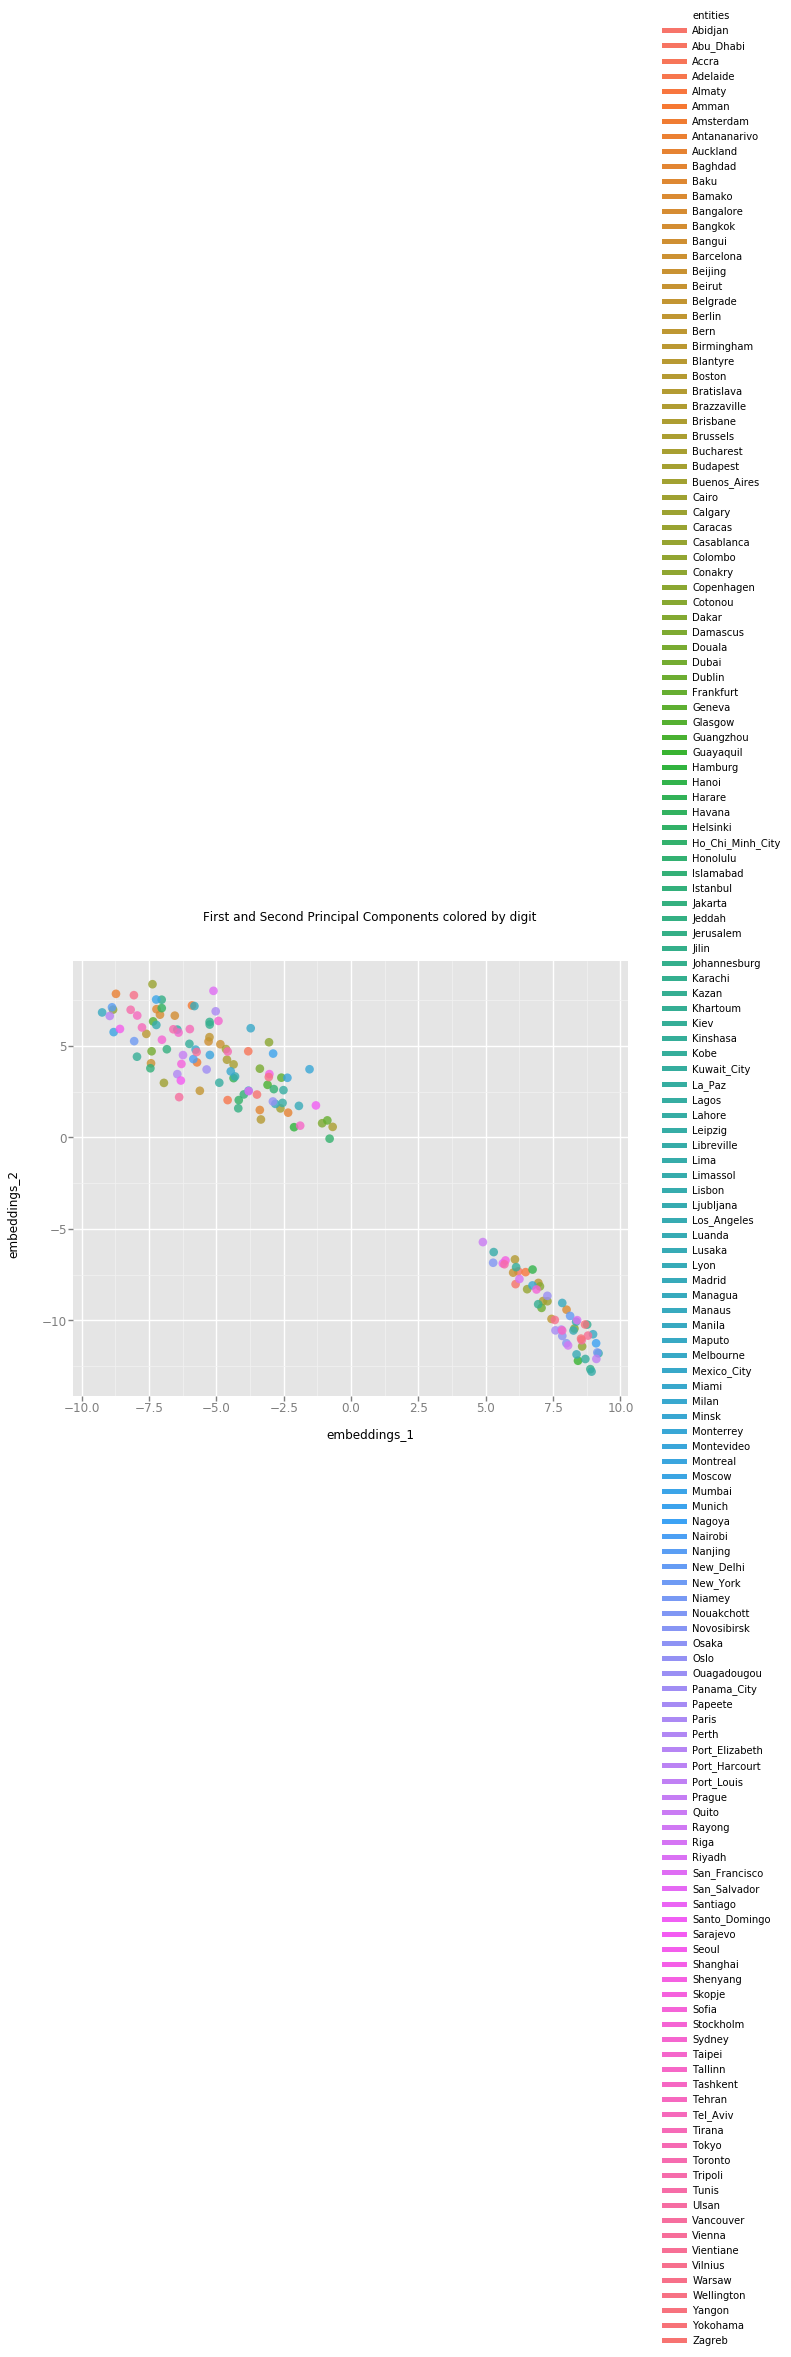

<ggplot: (8790543270671)>

In [209]:
chart = ggplot( data_frame_embedding, aes(x='embeddings_1', y='embeddings_2', color='entities') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

In [226]:
%matplotlib inline

In [227]:
import matplotlib.pyplot as plt

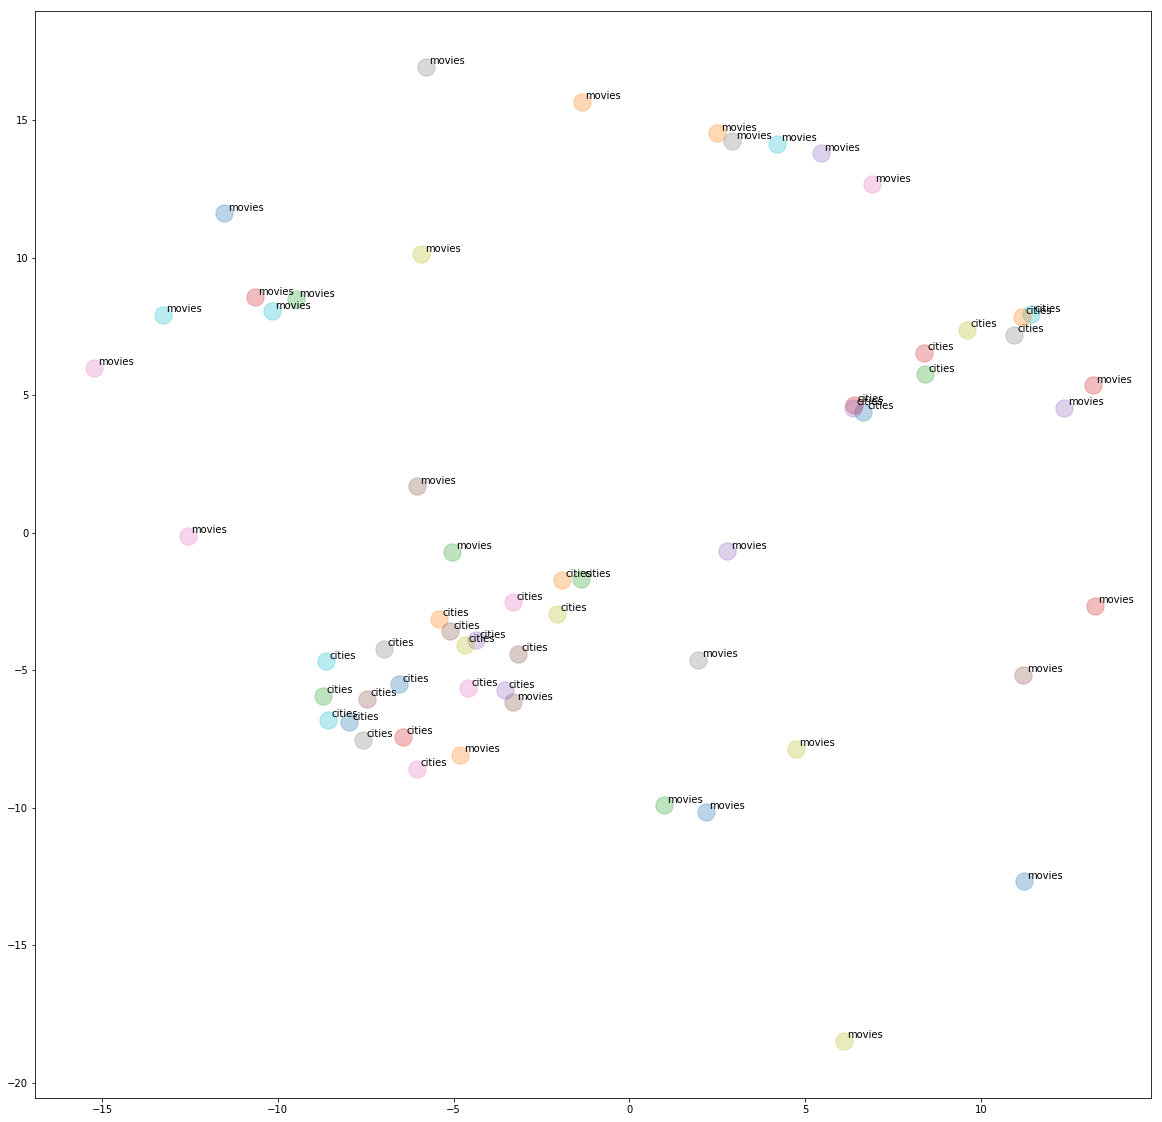

In [228]:
fig, ax = plt.subplots(figsize=(20,20))
for i in idx_final:
    x,y = data_frame_final.loc[i,'embeddings_1'],data_frame_final.loc[i,'embeddings_2']
    plt.scatter(x, y, s=300, alpha=0.3,cmap='viridis')
    plt.text(x+0.1,y+0.1,data_frame_final.loc[i,'entities'])
plt.show()

In [93]:
data_frame_final

,embeddings_1,embeddings_2,entities
371,2.339802,0.095567,Blood_Tea_and_Red_String
211,12.523002,5.479460,A_Nightmare_on_Elm_Street
743,-6.930490,10.338087,Following_Sean
1290,-1.611239,1.111293,Jonah_Hex_(film)
1355,9.082455,7.090378,Spice_World_(film)
1673,0.305597,-17.664127,Killers_(2010_film)
479,3.991861,-6.571800,Sleepwalk_with_Me
277,-12.886486,6.672430,Hoosiers
397,12.759974,4.351087,The_Hangover
482,10.610586,4.663326,Tangled
